SHIPS AND PLANES DETECTION FROM AERIAL SATELLITE IMAGES

We first make sure that we are actually using a GPU.

In [1]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

After that, we must mount our Google Drive file system to make it accessible from this notebook. Google will ask us for permission, we have to copy and paste the code that it provides us.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Let's look at an example image.

'./drive/MyDrive/Trabajo de FSI/Fotos/Ships/boat0.png'


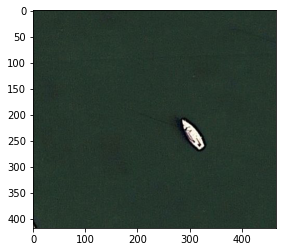

In [3]:
!ls "./drive/MyDrive/Trabajo de FSI/Fotos/Ships/boat0.png" 

from matplotlib.pyplot import imshow
import numpy as np
from PIL import Image

%matplotlib inline
pil_im = Image.open('./drive/MyDrive/Trabajo de FSI/Fotos/Ships/boat0.png', 'r')
imshow(np.asarray(pil_im))

We import the ImageDataGenerator class.

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

Now we instantiate the ImageDataGenerator class. For now, the only parameter we are going to define will be rescale. The images we have in our dataset are stored in three channels: red, green and blue. Each channel has a value, of type integer, in a range from 0 to 255. The first thing we need to do is rescale it to a range of values ​​of type float between 0 and 1. That's what rescale = 1 does. / 255.

In [ ]:
train_dataset = ImageDataGenerator(
        rescale=1./255)
validation_dataset = ImageDataGenerator(
        rescale=1./255)

Once we have the class instantiated in the train_dataset object, we invoke its image_dataset_from_directory (doc) method. Here we specify the folder where the images are, the size we want all of them to be, the batch size and the type of classification to be made: binary or categorical. Binary means that there are only two classes, categorical that there are more than two so, in this case, we do go for categorical.

In [ ]:
image_size = (150, 150)
batch_size = 32

train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    './drive/MyDrive/Trabajo de FSI/Fotos',
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
    label_mode='categorical'
)
validation_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    './drive/MyDrive/Trabajo de FSI/Fotos',
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
    label_mode='categorical'
)

train_ds = train_dataset.prefetch(buffer_size=32)
val_ds = validation_dataset.prefetch(buffer_size=32)

NameError: ignored

We define the model adding the different layers and compile it.

In [ ]:
# MODEL --------------------------------------------------

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Dense, Rescaling, Flatten
from tensorflow.keras.callbacks import EarlyStopping

model = keras.Sequential()
model.add(Rescaling(scale=(1./255),
                    offset=-1, 
                    input_shape=(150, 150, 3)))
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu')) #conv2d(batchSize, height, width, channels or filters)
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten()) # Convert the tensor into a vector
model.add(Dense(128, activation='relu')) # Fully connected of 128 neurons
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax')) 
model.summary()
# None means this dimension is variable.The first dimension in a keras model is always the batch size. You don't need fixed batch sizes, unless in very specific cases.

model.compile(loss=tf.keras.losses.categorical_crossentropy,
              optimizer=tf.keras.optimizers.Adam(1e-3),
              metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 150, 150, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 36, 36, 64)        0

we train the model with the .fit() function.

In [ ]:
# TRAINING --------------------------------------------------

epochs = 200

es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=10, restore_best_weights=True)

h = model.fit(
        train_dataset,
        epochs=epochs, 
        validation_data=validation_dataset,
        callbacks = [es]
        )

Epoch 1/200
139/139 [==============================] - 306s 2s/step - loss: 0.6058 - accuracy: 0.7106 - val_loss: 0.4634 - val_accuracy: 0.8043
Epoch 2/200
139/139 [==============================] - 19s 131ms/step - loss: 0.3705 - accuracy: 0.8570 - val_loss: 0.2778 - val_accuracy: 0.8804
Epoch 3/200
139/139 [==============================] - 19s 131ms/step - loss: 0.3180 - accuracy: 0.8799 - val_loss: 0.3201 - val_accuracy: 0.8768
Epoch 4/200
139/139 [==============================] - 19s 130ms/step - loss: 0.3232 - accuracy: 0.8710 - val_loss: 0.2998 - val_accuracy: 0.8687
Epoch 5/200
139/139 [==============================] - 19s 130ms/step - loss: 0.2980 - accuracy: 0.8814 - val_loss: 0.2609 - val_accuracy: 0.8995
Epoch 6/200
139/139 [==============================] - 19s 132ms/step - loss: 0.2287 - accuracy: 0.9174 - val_loss: 0.1672 - val_accuracy: 0.9447
Epoch 7/200
139/139 [==============================] - 19s 129ms/step - loss: 0.1845 - accuracy: 0.9310 - val_loss: 0.1339 - v

Training a model can take minutes, hours or several days. Therefore, once trained we will want to save it so that we can load it again and use it whenever we want. It is possible to save only the weights, only the architecture or the weights and the architecture together. (Doc)

Saving and loading the weights
To save only the weights we will use the save_weights method. To load them we will use load_weights

Saving and loading the model
To save and load only the model we will use model.to_json () and model_from_json ()

Saving it and loading it all
To save and load everything we will do model.save () and load_model (). Here it is important to note that the training settings are also saved, so it is possible to continue retraining.

In [ ]:
# SAVING --------------------------------------------------

model.save("/content/drive/MyDrive/Trabajo de FSI/Ships&PlanesModel.h5")

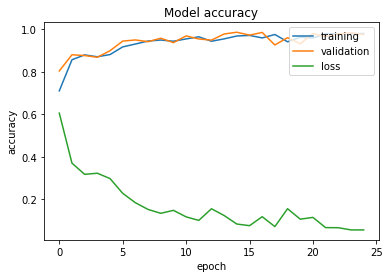

In [ ]:
import matplotlib.pyplot as plt

plt.plot(h.history['accuracy'])
plt.plot(h.history['val_accuracy'])
plt.plot(h.history['loss'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training', 'validation','loss'], loc='upper right')
plt.show()

EVALUATION OF RESULTS

              precision    recall  f1-score   support

           0     0.9836    0.9917    0.9876       604
           1     1.0000    0.9778    0.9888       180
           2     0.9843    0.9812    0.9828       320

    accuracy                         0.9864      1104
   macro avg     0.9893    0.9836    0.9864      1104
weighted avg     0.9865    0.9864    0.9864      1104



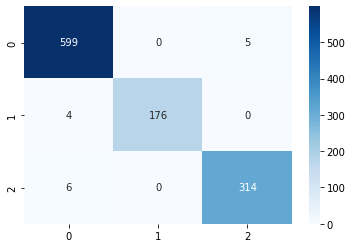

In [ ]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

results = np.concatenate([(y, model.predict(x=x)) for x, y in val_ds], axis=1)

predictions = np.argmax(results[0], axis=1)
labels = np.argmax(results[1], axis=1)

cf_matrix = confusion_matrix(labels, predictions)

sns.heatmap(cf_matrix, annot=True, fmt="d", cmap="Blues")

print(classification_report(labels, predictions, digits = 4))

CATEGORIES
0 - No Ships & No Planes
1 - Planes
2 - Ships

This image belongs to category =  1 



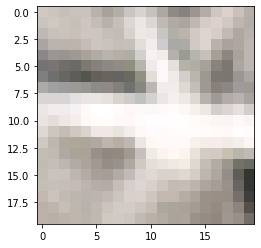

In [ ]:
# PRODUCTION ----------------------------------------------
import keras
from matplotlib.pyplot import imshow
import numpy as np
from PIL import Image
import tensorflow as tf
model = keras.models.load_model("./drive/MyDrive/Trabajo de FSI/Ships&PlanesModel.h5")
image_size = (150, 150)
#imgDirectory = "./drive/MyDrive/Trabajo de FSI/Fotos/No_ships/SeaLake_68.jpg"
#imgDirectory = "./drive/MyDrive/Trabajo de FSI/Fotos/Ships/boat515.png"
imgDirectory = "./drive/MyDrive/Trabajo de FSI/Fotos/Planes/1__20151112_182718_0c18__-118.411473369_33.9451968407.png"
img = keras.preprocessing.image.load_img(
    imgDirectory , target_size=image_size
)
%matplotlib inline
pil_im = Image.open(imgDirectory, 'r')
imshow(np.asarray(pil_im))

img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
print("CATEGORIES\n0 - No Ships & No Planes\n1 - Planes\n2 - Ships\n")
print("This image belongs to category = ",np.argmax(predictions[0]),"\n")
#Belongs to Planes Category